## 1. Dataset Preparation
### 1.1 Loading Datasets

**Document Type** = Article, Article in Press, Review, Book Chapter, Letter, Note

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import scipy.stats as stats
import pickle

from itertools import chain, combinations
from scipy.cluster.hierarchy import dendrogram
from unidecode import unidecode
from collections import Counter
from operator import itemgetter

In [ ]:
authorsPath = "data/autori.xlsx"
epidemiologyPath = "data/epidemiology.xlsx"
immunologyPath = "data/immunology.xlsx"
infectiveDiseasesPath = "data/infectious_diseases.xlsx"
microbiologyPath = "data/microbiology.xlsx"

authorsData = pd.read_excel(authorsPath)

epidemiologyData = pd.read_excel(epidemiologyPath)
immunologyData = pd.read_excel(immunologyPath)
infectiveDiseasesData = pd.read_excel(infectiveDiseasesPath)
microbiologyData = pd.read_excel(microbiologyPath)

documentTypeSet = {"Article", "Article in Press", "Review", "Book Chapter", "Letter", "Note"}

duplicatesSubset = ['Authors', 'Title', 'Year', 'Source title', 'Document Type']

print(f"Autori - Rows: {authorsData.shape[0]} - Cols: {authorsData.shape[1]}")
print(f"Epidemiology - Rows: {epidemiologyData.shape[0]} - Cols: {epidemiologyData.shape[1]}")
print(f"Immunology - Rows: {immunologyData.shape[0]} - Cols: {immunologyData.shape[1]}")
print(f"Infectious diseases - Rows: {infectiveDiseasesData.shape[0]} - Cols: {infectiveDiseasesData.shape[1]}")
print(f"Microbiology - Rows: {microbiologyData.shape[0]} - Cols: {microbiologyData.shape[1]}")

# Global helper functions

def convertSerbianCharsToAscii(df, columns):
    serbianLatinCharsMap = {
        'ć': 'c',
        'č': 'c',
        'đ': 'dj',
        'š': 's',
        'ž': 'z',
        
        'Ć': 'C',
        'Č': 'C',
        'Đ': 'Dj',
        'Š': 'S',
        'Ž': 'Z',
    }
    
    for column in columns:
        df[column] = df[column].apply(lambda x: unidecode(x,  errors='strict'))


### 1.2 Dataset Preprocessing with Authors
Some authors were identified whose **Number of Publications** and **H-index** are null or unknown.  

**Number of Publications** – will be set to 0 for now, and we will attempt to fill it in later from the corresponding department dataset.  
**H-index** – will be set to 0.  
**Short Name** – a new column has been added representing the author's short name.


In [ ]:
authorsData.fillna(0, inplace=True)
authorsData['H index'] = authorsData['H index'].replace('?', 0)
authorsData = authorsData.astype({'H index': int, 'Number of rows': int})

convertSerbianCharsToAscii(authorsData, ['Name', 'Surname', 'Department'])

authorsData.insert(0,'id_author',0)
authorsData['id_author'] = authorsData.reset_index().index + 1

authorsData['Name'] = authorsData['Name'].apply(lambda x: x.strip())
authorsData['Surname'] = authorsData['Surname'].apply(lambda x: x.strip().replace('-', ' '))


authorsData['Short name'] = authorsData['Surname'] + ' ' + authorsData['Name'].str[0] + '.'


# duplicatedAuthors = authorsData.duplicated(subset=['Name', 'Surname'])
# print(duplicatedAuthors)

print(authorsData.dtypes)

# print(authorsData['Short name'])

print(authorsData['Short name'].is_unique)

# print(authorsData)

authorsData.head(-1)

authorsData.to_excel("data/authorsData.xlsx") 

## 1.3 Preparation of Publication Datasets
* Serbian Latin characters were removed  
* A new column 'Department name' was added  
* The following columns were removed as irrelevant: 'Art. No.', 'Page start', 'Page end', 'Page count', 'Link', 'Source', 'Volume', 'Issue'  
* Publications were filtered by 'Document Type' ("Article", "Article in Press", "Review", "Book Chapter", "Letter", "Note")  
* Duplicates were removed – A publication is considered a duplicate if the columns 'Authors', 'Title', 'Year', and 'Source title' are identical.

### 1.3.1 Preparation of the Dataset for Epidemiology


In [ ]:
epidemiologyDataFiltered = epidemiologyData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars

convertSerbianCharsToAscii(epidemiologyDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column

epidemiologyDataFiltered['Research area'] = 'Epidemiology'

# Removing unnecessary charactes from 'Author' and 'Authors' columns

epidemiologyDataFiltered['Author'] = epidemiologyDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
epidemiologyDataFiltered['Authors'] = epidemiologyDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))

# Drop unnecessary columns
epidemiologyDataFiltered.drop(columns=['Art. No.'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Page start'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Page end'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Page count'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Link'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Source'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Volume'], inplace=True)
epidemiologyDataFiltered.drop(columns=['Issue'], inplace=True)

# Replacing NaN Values

epidemiologyDataFiltered['Cited by'] = epidemiologyDataFiltered['Cited by'].fillna(0)

# Fixing types
epidemiologyDataFiltered = epidemiologyDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(epidemiologyDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'

epidemiologyDataFiltered = epidemiologyDataFiltered[epidemiologyDataFiltered['Document Type'].isin(documentTypeSet)]

# Checking duplcates and dropping them
epidemiologyDataCountOld = epidemiologyDataFiltered.shape[0]

epidemiologyDataFiltered = epidemiologyDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

epidemiologyDataCountNew = epidemiologyDataFiltered.shape[0]

print(f"Number of rows before deduplication '{epidemiologyDataCountOld}'")
print(f"Number of rows after deduplication '{epidemiologyDataCountNew}'")
print(f"Total removed'{epidemiologyDataCountOld - epidemiologyDataCountNew}' scientific papers")

epidemiologyDataFiltered.head(20)

### 1.3.2 Preparation of Dataset for Immunology

In [ ]:
immunologyDataFiltered = immunologyData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars

convertSerbianCharsToAscii(immunologyDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column

immunologyDataFiltered['Research area'] = 'Immunology'

# Removing unnecessary charactes from 'Author' and 'Authors' columns

immunologyDataFiltered['Author'] = immunologyDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
immunologyDataFiltered['Authors'] = immunologyDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))

# Drop unnecessary columns
immunologyDataFiltered.drop(columns=['Art. No.'], inplace=True)
immunologyDataFiltered.drop(columns=['Page start'], inplace=True)
immunologyDataFiltered.drop(columns=['Page end'], inplace=True)
immunologyDataFiltered.drop(columns=['Page count'], inplace=True)
immunologyDataFiltered.drop(columns=['Link'], inplace=True)
immunologyDataFiltered.drop(columns=['Source'], inplace=True)
immunologyDataFiltered.drop(columns=['Volume'], inplace=True)
immunologyDataFiltered.drop(columns=['Issue'], inplace=True)


# Replacing NaN Values

immunologyDataFiltered['Cited by'] = immunologyDataFiltered['Cited by'].fillna(0)

# Fixing types
immunologyDataFiltered = immunologyDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(immunologyDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'

immunologyDataFiltered = immunologyDataFiltered[immunologyDataFiltered['Document Type'].isin(documentTypeSet)]


# Checking duplcates and dropping them
immunologyDataCountOld = immunologyDataFiltered.shape[0]

immunologyDataFiltered = immunologyDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

immunologyDataCountNew = immunologyDataFiltered.shape[0]

print(f"Number of rows before deduplication '{immunologyDataCountOld}'")
print(f"Number of rows after deduplication '{immunologyDataCountNew}'")
print(f"Total removed '{immunologyDataCountOld - immunologyDataCountNew}' scientific papaers")
print(f"Title unique: {immunologyDataFiltered['Title'].is_unique}")

immunologyDataFiltered.head(20)

### 1.3.3 Priprema Dataset-a za Infektivne bolesti

In [ ]:
infectiveDiseasesDataFiltered = infectiveDiseasesData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars
convertSerbianCharsToAscii(infectiveDiseasesDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column
infectiveDiseasesDataFiltered['Research area'] = 'Infective Diseases'

# Removing unnecessary charactes from 'Author' and 'Authors' columns
infectiveDiseasesDataFiltered['Author'] = infectiveDiseasesDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
infectiveDiseasesDataFiltered['Authors'] = infectiveDiseasesDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))

# Drop unnecessary columns
infectiveDiseasesDataFiltered.drop(columns=['Art. No.'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Page start'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Page end'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Page count'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Link'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Source'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Volume'], inplace=True)
infectiveDiseasesDataFiltered.drop(columns=['Issue'], inplace=True)


# Replacing NaN Values
infectiveDiseasesDataFiltered['Cited by'] = infectiveDiseasesDataFiltered['Cited by'].fillna(0)

# Fixing types
infectiveDiseasesDataFiltered = infectiveDiseasesDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(infectiveDiseasesDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'
infectiveDiseasesDataFiltered = infectiveDiseasesDataFiltered[infectiveDiseasesDataFiltered['Document Type'].isin(documentTypeSet)]


# Checking duplcates and dropping them
infectiveDiseasesDataCountOld = infectiveDiseasesDataFiltered.shape[0]

infectiveDiseasesDataFiltered = infectiveDiseasesDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

infectiveDiseasesDataCountNew = infectiveDiseasesDataFiltered.shape[0]

print(f"Number of rows before deduplication '{infectiveDiseasesDataCountOld}'")
print(f"Number of rows after deduplication '{infectiveDiseasesDataCountNew}'")
print(f"Total removed '{infectiveDiseasesDataCountOld - infectiveDiseasesDataCountNew}' scientific papaers")

infectiveDiseasesDataFiltered.head(20)

### 1.3.4 Preparation of Dataset for Microbiology

In [ ]:
microbiologyDataFiltered = microbiologyData.copy(deep=True)

# Replacing Serbian Latin specific chars with Ascii chars
convertSerbianCharsToAscii(microbiologyDataFiltered, ['Author', 'Authors', 'Title', 'Source title'])

# Adding 'Department name' column
microbiologyDataFiltered['Research area'] = 'Microbiology'

# Removing unnecessary charactes from 'Author' and 'Authors' columns
microbiologyDataFiltered['Author'] = microbiologyDataFiltered['Author'].apply(lambda x: x.strip().replace('-', ' '))
microbiologyDataFiltered['Authors'] = microbiologyDataFiltered['Authors'].apply(lambda x: x.strip().replace('-', ' '))

# Drop unnecessary columns
microbiologyDataFiltered.drop(columns=['Art. No.'], inplace=True)
microbiologyDataFiltered.drop(columns=['Page start'], inplace=True)
microbiologyDataFiltered.drop(columns=['Page end'], inplace=True)
microbiologyDataFiltered.drop(columns=['Page count'], inplace=True)
microbiologyDataFiltered.drop(columns=['Link'], inplace=True)
microbiologyDataFiltered.drop(columns=['Source'], inplace=True)
microbiologyDataFiltered.drop(columns=['Volume'], inplace=True)
microbiologyDataFiltered.drop(columns=['Issue'], inplace=True)


# Replacing NaN Values
microbiologyDataFiltered['Cited by'] = microbiologyDataFiltered['Cited by'].fillna(0)

# Fixing types
microbiologyDataFiltered = microbiologyDataFiltered.astype(
    {
        'Year': int, 
        'Cited by': int
    }
)
print(microbiologyDataFiltered.dtypes)

# Filtering rows by 'Documnet Type'
microbiologyDataFiltered = microbiologyDataFiltered[microbiologyDataFiltered['Document Type'].isin(documentTypeSet)]


# Checking duplcates and dropping them
microbiologyDataCountOld = microbiologyDataFiltered.shape[0]

microbiologyDataFiltered = microbiologyDataFiltered.drop_duplicates(
    subset=duplicatesSubset,
    keep="first",
    inplace=False
)

microbiologyDataCountNew = microbiologyDataFiltered.shape[0]

print(f"Number of rows before deduplication '{microbiologyDataCountOld}'")
print(f"Number of rows after deduplication '{microbiologyDataCountNew}'")
print(f"Total removed '{microbiologyDataCountOld - microbiologyDataCountNew}' scientific papaers")

microbiologyDataFiltered.head(20)

## 1.4 Combining Datasets with scientific papers

In [ ]:
# Combining filtered epidemilogoy, immunology, infectiveDiseases and microbiology dataframes
combinedWorks = pd.concat(
    [
        epidemiologyDataFiltered,
        immunologyDataFiltered,
        infectiveDiseasesDataFiltered,
        microbiologyDataFiltered
        
    ], 
    ignore_index=True
)

combinedWorks = combinedWorks.drop_duplicates(
    subset=['Authors', 'Title', 'Year', 'Source title', 'Cited by', 'Document Type'],
    keep="first",
    inplace=False
)

combinedWorks.insert(0,'id_work',0)
combinedWorks['id_work'] = combinedWorks.reset_index().index + 1
combinedWorks.drop(columns=['Author'], inplace=True)

print(f"Combined dataset - Rows: {combinedWorks.shape[0]} - Cols: {combinedWorks.shape[1]}")
print(combinedWorks.dtypes)

combinedWorks.to_excel("data/combinedWorks.xlsx") 

combinedWorks.head(20)

# combinedWorks.groupby('Source title').size().reset_index(name='Num of work per Soruce title').sort_values(by='Num of work per Soruce title', ascending=False).head(50)


## 2. Research questions and objectives
### 2.1 Statistical data processing
#### 1. What is the number of works by each author? Use both whole and fractional counting. Who are the most productive scientists in the field of research and which department do they belong to?

In [38]:
# Separation of groups of authors into separate lines
workPerAuthor = combinedWorks.assign(Authors=combinedWorks['Authors'].str.split(',')).explode('Authors')
workPerAuthor.rename(columns={'Authors': 'Author'}, inplace=True)
workPerAuthor['Author'] = workPerAuthor['Author'].apply(lambda x: x.strip())

def f(x, short_name):
    if short_name in x:
        return short_name
    else:
        return x

for index, row in authorsData.iterrows():
    workPerAuthor['Author'] = workPerAuthor['Author'].apply(f, short_name = row['Short name'])

workPerAuthor.to_excel("data/workPerAuthor.xlsx") 

# Joined authorsData and workPerAuthor
authorsAndWorks = pd.merge(authorsData, workPerAuthor, left_on='Short name', right_on='Author', how='inner')

authorsAndWorks.to_excel("data/authorsAndWorks.xlsx") 

In [10]:
# Calacualte number of works per Author by workPerAuthor DataFrame and join with authorsData DataFrame

numOfWorksPerAuthor = workPerAuthor.groupby('Author').size().reset_index(name='Num of works per Author').sort_values(by='Num of works per Author', ascending=False)
    
numOfWorksPerAuthor.to_excel("data/workPerAuthorSorted.xlsx")

combineAuthorsAndNumOfWorks = pd.merge(numOfWorksPerAuthor, authorsData, left_on='Author', right_on='Short name', how='inner')
combineAuthorsAndNumOfWorks.to_excel("data/firstQuestion.xlsx")

# Show the results
# combineAuthorsAndNumOfWorks.sort_values(by='Num of works per Author', ascending=False).head(6)

# Show the results
# rezultat.head(80)

#### 2. What is the average number of co-authors per author ?

In [ ]:
# id_work, Authors, Title, Year, Soruce title, Cited by, Document Type, Research area

numOfAuthorsPerWork = workPerAuthor.groupby('id_work').size().reset_index(name='Num of authors per Work')
# numOfAuthorsPerWork.head(5)

numOfWorksPerAuthor = authorsAndWorks.groupby('Author').size().reset_index(name='Num of works per Author').sort_values(by='Num of works per Author', ascending=False)
# numOfWorksPerAuthor.head(70)

result1 = pd.merge(numOfAuthorsPerWork, authorsAndWorks, on='id_work', how='inner')
# result1.head(70)

result2 = pd.merge(result1, numOfWorksPerAuthor, on='Author', how='inner')
# result.head(70)

result2 = result2.groupby('Author')['Num of authors per Work'].sum().reset_index(name='Sum of Co Authors')
# result2.head(70)

result2 = pd.merge(result2, numOfWorksPerAuthor, on='Author', how='inner')
# result2.head(70)

result2['AVG CoAuthors per Author'] = (result2['Sum of Co Authors'] - result2['Num of works per Author']) / result2['Num of works per Author']
result2.sort_values(by='Sum of Co Authors', ascending=False).head(70)

#### 3. Based on the available data, determine the H-index of each scientist and compare it with the available H-index in the file authors.xlsx ?

In [ ]:
# The H-index matches us to a large extent in the given excel table authors.xlsx
authorWorksCitedBy = {}
authorHIndex = {}

for index, row in authorsData.iterrows():
    authorWorksCitedBy[row['Short name']] = []

for index, row in authorsAndWorks.iterrows():
    authorWorksCitedBy[row['Short name']].append(row['Cited by'])

for author in authorWorksCitedBy:
    authorWorksCitedBy[author].sort(reverse=True)

for author in authorWorksCitedBy:
    HIndex = 0
    
    for index, item in enumerate(authorWorksCitedBy[author]):
        if item >= index + 1:
            HIndex = index + 1
        else:
            break
    
    authorHIndex[author] = HIndex

authorsHIndex = pd.DataFrame(list(authorHIndex.items()), columns=['Short name', 'Calculate H index'])

combinedAuthorsAndHIndex = pd.merge(authorsHIndex, authorsData, on='Short name', how='inner')
combinedAuthorsAndHIndex.head(80)


#### 4. Which departments are the most productive in terms of scientific production and citations in journals based on the available data ?

In [ ]:
citedByPerAuthor = authorsAndWorks.groupby('Short name')['Cited by'].sum().reset_index(name='Sum of Cited by')
# citedByPerAuthor.head(80)

numOfWorksPerAuthor = authorsAndWorks.groupby('Short name').size().reset_index(name='Num of works per Author')
# numOfWorksPerAuthor.head(80)

result = pd.merge(citedByPerAuthor, numOfWorksPerAuthor, on='Short name', how='inner')
result = pd.merge(authorsData, result, on='Short name', how='inner')

result = result.groupby('Department').agg({'Sum of Cited by':'sum','Num of works per Author':'sum'})
result.sort_values(by='Sum of Cited by', ascending=False).head(10)

#### 5. In which years were the authors most productive at the faculty level and individual departments?

###### 5.1. By faculty level

In [ ]:
productivityPerYear = authorsAndWorks.groupby('Year').size().reset_index(name='Num of works')
productivityPerYear.sort_values(by='Num of works', ascending=False).head(100)

###### 5.2. By department level

In [ ]:
productivityPerYearAndDeprtment = authorsAndWorks.groupby(['Year', 'Department']).size().reset_index(name='Num of works')
productivityPerYearAndDeprtment.sort_values(by=['Year', 'Num of works'], ascending=[False, False]).head(50)

#### 6. In which magazines is the most published on average ?

In [ ]:
numOfWorlsPerArticle = authorsAndWorks.groupby(['Source title']).size().reset_index(name='Num of works')
numOfWorlsPerArticle.sort_values(by='Num of works', ascending=False).head(10)

#### 7. Are there differences between departments in terms of volume and frequency of publication in journals ?
From task number 6, it can be seen that the journal 'Archives of Biological Sciences' has the most publications, and in the picture below we can see that there is not an excessively large oscillation in terms of publications by journals by different departments.

In [ ]:
numOfWorksPerArticleAndDepartment = authorsAndWorks.groupby(['Source title', 'Year','Department']).size().reset_index(name='Num of works')
# numOfWorksPerArticleAndDepartment.sort_values(by='Year', ascending=False).head(70)

grafik = sns.barplot(
    data=productivityPerYearAndDeprtment.sort_values(by=['Year'], ascending=[False]).head(36),
    x='Year', 
    y='Num of works', 
    hue='Department'
)
sns.move_legend(grafik, "upper left", bbox_to_anchor=(1, 1))
plt.show()

#### 8. Is there a difference in the average number of authors per paper in journals per department ?

In [ ]:
numOfAuthorsPerDepartment = authorsData.groupby('Department').size().reset_index(name='Num of authors')
# numOfAuthorsPerDepartment.head(5)

numOfWorksPerDepratment = combineAuthorsAndNumOfWorks.groupby('Department')['Num of works per Author'].sum().reset_index(name='Num of works')
# numOfWorksPerDepratment.head(5)

result = pd.merge(numOfAuthorsPerDepartment, numOfWorksPerDepratment, on='Department', how='inner')

result['Author per work'] = result['Num of authors'] / result['Num of works']
result['AVG Author per work'] = result['Author per work'].mean()
result.head(5)

#### 9. What is the ratio of the number of co-authors from the faculty in relation to the number of authors outside the faculty by departments and at the level of the entire faculty ?

In [ ]:
numOfDomesticAuthorsPerWork = authorsAndWorks.groupby(['id_work', 'Title']).size().reset_index(name='Num of domestic authors')
# numOfDomesticAuthorsPerWork.head(20)

foreginAuthorAndWorks = pd.merge(workPerAuthor, authorsData, left_on='Author', right_on='Short name', how='left')
filtered_df = foreginAuthorAndWorks[foreginAuthorAndWorks['Author'].isin(authorsData['Short name'])]
foreginAuthorAndWorks = foreginAuthorAndWorks.drop(filtered_df.index)
# foreginAuthorAndWorks.head(40)

numOfForeginAuthorsPerWork = foreginAuthorAndWorks.groupby(['id_work', 'Title']).size().reset_index(name='Num of foregin authors')
# numOfForeginAuthorsPerWork.head(40)

numOfForeginAndDomesitAuthorsPerWork = pd.merge(numOfDomesticAuthorsPerWork, numOfForeginAuthorsPerWork, on=['id_work', 'Title'])
# numOfForeginAndDomesitAuthorsPerWork.head(40)

mergedDomesticAuhorsWorksAndNumOfCoAuthors = pd.merge(authorsAndWorks, numOfForeginAndDomesitAuthorsPerWork, on='id_work', how='inner')
# result9.head(25)

noDuplicatedWorks = mergedDomesticAuhorsWorksAndNumOfCoAuthors[~mergedDomesticAuhorsWorksAndNumOfCoAuthors.duplicated(['id_work', 'Department'], keep=False)]
# df_no_duplicates.head(10)

groupbyDepartment = noDuplicatedWorks.groupby('Department')[['Num of domestic authors', 'Num of foregin authors']].sum()
groupbyDepartment['The ratio of domestic and foregin authors'] = groupbyDepartment['Num of domestic authors'] / groupbyDepartment['Num of foregin authors']

groupbyDepartment.head(5)


In [ ]:
foreginAuthorAndWorks.groupby('Author').size().reset_index(name='Num of works per Author').sort_values(by='Num of works per Author', ascending=False).head(20)


### 2.2 Basic characterization of modeled networks

In [ ]:
# TODO: Export DataFrame 'authorsAndWorks' via Pickle to a file and load it here
inputCleanData = authorsAndWorks
labels = set(inputCleanData['Short name'].unique())
print(f"There are { len(labels) } different authors")

In [ ]:
reducedAuthorsAndWorks = inputCleanData[['id_work', 'Author']]

combinations_df = pd.merge(reducedAuthorsAndWorks, reducedAuthorsAndWorks, on='id_work')
# combinations_df.head(80)

# Filtering pairs of authors that are not the same (to avoid pairs of authors with themselves)
filtered_combinations_df = combinations_df[combinations_df['Author_x'] != combinations_df['Author_y']]

# Creating a new DataFrame with columns 'id_work', 'author' and 'co-author'
result_df = filtered_combinations_df[['id_work', 'Author_x', 'Author_y']].rename(columns={'Author_x': 'Author', 'Author_y': 'Co-Author'})
result_df.head(-1)

In [ ]:
G = nx.Graph()
G.add_nodes_from(labels)

for _, idWork, author, coAuthor in result_df.itertuples():
    if (author, coAuthor) in G.edges:
        G.edges[author, coAuthor]['weight'] += 1
    else:
        G.add_edge(author, coAuthor, weight=1)

print(G.edges.data("weight"))

nx.write_gml(G, "models/mreza_jedan.gml")

In [ ]:
H = G.to_undirected()

print("Number of connected components: " , nx.number_connected_components(H))

connected_componnets = sorted(nx.connected_components(H), key=len, reverse=True)
print("Size of connected components:")
for x in connected_componnets:
    print(len(x) , "  ")
    
print( "Average clustering coefficient:" , nx.average_clustering(H), ", Global clustering coefficient: " , nx.transitivity(H) )

Max lokalni cc: 0.09200531258775885
Prosečan cc: 0.5569535644581753
Lokalni stepeni klasterisanja koji nisu nula:
                    Author        Cc
7              Markovic M.  0.012048
45              Nikolic A.  0.012838
8               Vukovic D.  0.016438
25              Perovic V.  0.016991
14            Trajkovic V.  0.017067
33     Sipetic Grujicic S.  0.017296
1                Vujcic I.  0.019203
42       Markovic Denic L.  0.019524
6           Stamenkovic M.  0.021617
15           Stevanovic G.  0.021681
3                 Ranin J.  0.022477
37           Maksimovic J.  0.022680
39           Maksimovic N.  0.022936
21             Mitrovic S.  0.024665
44               Dzamic A.  0.024781
35              Pravica V.  0.026412
17    Arsic Arsenijevic V.  0.026485
31                Mijac V.  0.026679
20             Knezevic A.  0.027172
2            Pekmezovic T.  0.027175
36     Vukovic Petrovic I.  0.027267
32            Lazarevic I.  0.027478
0               Nikolic V.  0.02747

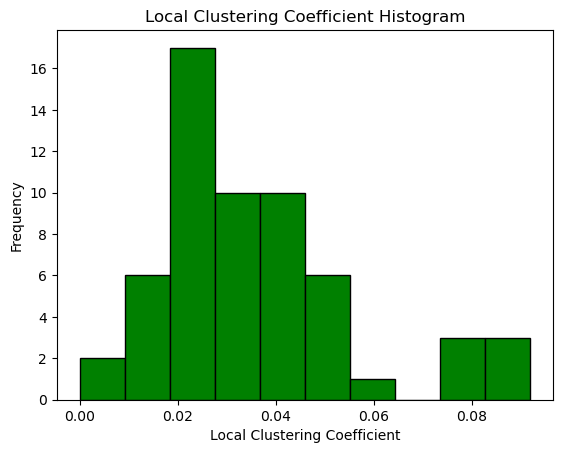

In [25]:
# Local Degree of clustering
author, clustering_coef = zip(*nx.clustering(G, weight = "weight").items())
no_zero = [(auth, cc)  for auth, cc in zip(author, clustering_coef) if cc > 0]

df = pd.DataFrame(no_zero, columns = ["Author", "Cc"])
df.sort_values('Cc', inplace = True)

max_local_degree_of_clustering = max(clustering_coef)

average_degree_of_clustering = nx.average_clustering(G)

print(f"Max lokal cc: {max_local_degree_of_clustering}")
print(f"Average cc: {average_degree_of_clustering}")
print("Lokal degree of clustering which is not a zero:")
print(df)

# ax = df.plot.scatter(x='Author', y='Cc')
# ax.set_xscale("log")
# ax.set_yscale("log");


plt.hist(clustering_coef, bins=10, edgecolor='black', color = "green")

# Postavite naslove i oznake osa
plt.title('Local Clustering Coefficient Histogram')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')

plt.savefig('images/local_cc_main_network.png')
# Prikazivanje histograma
plt.show()


In [26]:
def plot_deg_frequency(G, weighted = False, xscale = "log", yscale = "log"):

    if weighted:
        degrees = G.degree(weight="weight")
    else:
        degrees = G.degree()
        
    _, deg_list = zip(*degrees)
    deg_counts = Counter(deg_list)        
    print(deg_counts)
    x, y = zip(*deg_counts.items())                                                      

    plt.figure(1)   

    # prep axes   
    if weighted:
        plt.xlabel('weighted degree')  
    else:
        plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(x))  

    plt.ylabel('frequency')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(y))                                                                                                             
                                                                                                                                                                                                    
    plt.scatter(x, y, marker='.')                                                                                                    
    plt.show()


Nodes: 58
Edges: 307
Counter({10: 9, 9: 7, 8: 7, 13: 7, 11: 6, 14: 6, 12: 6, 6: 4, 7: 2, 16: 2, 18: 1, 4: 1})


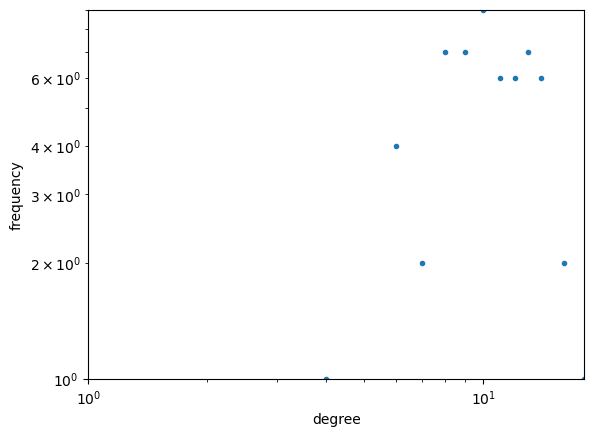

In [27]:
n = G.number_of_nodes()
m = G.number_of_edges()

print(f"Nodes: {n}")
print(f"Edges: {m}")

Gnm = nx.gnm_random_graph(n, m) 

# plot_deg_frequency(Gnm, xscale = 'linear', yscale = 'linear')
plot_deg_frequency(Gnm, xscale = 'log', yscale = 'log')

0.18572292800967938
Broj čvorova originalne mreže minus broj čvorova u ER mreži iznosi 33, što je odstupanje od 10.749185667752442%
Counter({8: 14, 10: 9, 7: 6, 12: 6, 11: 5, 14: 3, 5: 3, 13: 3, 9: 3, 6: 3, 16: 2, 4: 1})


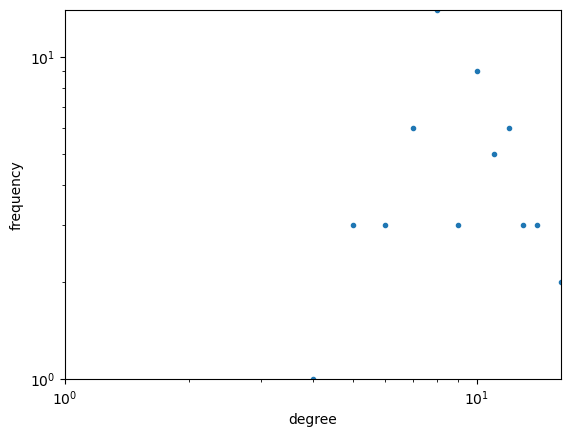

Max lokalni cc Erods-Reny mreze: 0.38095238095238093
Prosečan cc Erods-Reny mreze: 0.16885781842678396
Lokalni stepeni klasterisanja koji nisu nula Erods-Reny mreze:
    Author        Cc
23      23  0.066667
35      36  0.071429
16      16  0.071429
28      29  0.075758
31      32  0.088889
22      22  0.100000
9        9  0.107143
12      12  0.107143
29      30  0.107143
30      31  0.109890
44      45  0.111111
40      41  0.111111
50      51  0.125000
5        5  0.131868
54      55  0.133333
37      38  0.133333
25      26  0.136364
45      46  0.138889
24      25  0.142857
43      44  0.142857
32      33  0.142857
36      37  0.142857
4        4  0.145455
19      19  0.145455
47      48  0.145455
38      39  0.150000
11      11  0.151515
21      21  0.151515
20      20  0.153846
3        3  0.163636
18      18  0.166667
55      56  0.166667
15      15  0.166667
6        6  0.166667
39      40  0.177778
0        0  0.178571
14      14  0.178571
2        2  0.178571
13      13  0.1

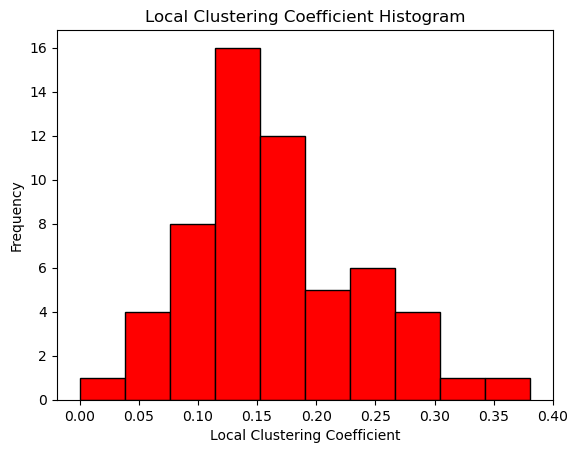

In [28]:
# Erdos-Renyi mreza N=58 (broj cvorova - autora)

p = ( 2*float(m) ) / ( n* (n-1) )
print(p)

er_mreza = nx.erdos_renyi_graph(n,p)


delta_m = m - er_mreza.number_of_edges()
print(f"Broj čvorova originalne mreže minus broj čvorova u ER mreži iznosi {delta_m}, što je odstupanje od {abs(float(delta_m)) * 100 / m}%")

# plot_deg_frequency(er_mreza, xscale = 'linear', yscale = 'linear')
plot_deg_frequency(er_mreza, xscale = 'log', yscale = 'log')


# Lokalni Stepen klasterizacije

author, clustering_coef = zip(*nx.clustering(er_mreza, weight = "weight").items())

nenula = [(auth, cc)  for auth, cc in zip(author, clustering_coef) if cc > 0]

df = pd.DataFrame(nenula, columns = ["Author", "Cc"])
df.sort_values('Cc', inplace = True)

max_lokalni_stepen_klasterisanja = max(clustering_coef)

prosecni_stepen_klasterisanja = nx.average_clustering(er_mreza)

print(f"Max lokalni cc Erods-Reny mreze: {max_lokalni_stepen_klasterisanja}")
print(f"Prosečan cc Erods-Reny mreze: {prosecni_stepen_klasterisanja}")
print("Lokalni stepeni klasterisanja koji nisu nula Erods-Reny mreze:")
print(df)

plt.hist(clustering_coef, bins=10, edgecolor='black', color = "red")

# Postavite naslove i oznake osa
plt.title('Local Clustering Coefficient Histogram')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')

plt.savefig('images/local_cc_er_network.png')

# Prikazivanje histograma
plt.show()

Max lokalni cc Random scale-free mreze: 0.3404521644800339
Prosečan cc Random scale-free mreze: 0.15143195642388285
Lokalni stepeni klasterisanja koji nisu nula Random scale-free mreze:
    Author        Cc
9       12  0.004762
0        0  0.021711
3        4  0.024182
1        1  0.050733
4        7  0.055780
2        2  0.065849
7       10  0.090072
15      47  0.100000
6        8  0.125992
8       11  0.200000
14      29  0.200000
10      13  0.209652
5        3  0.226480
11      20  0.270217
13      28  0.270217
12      22  0.340452


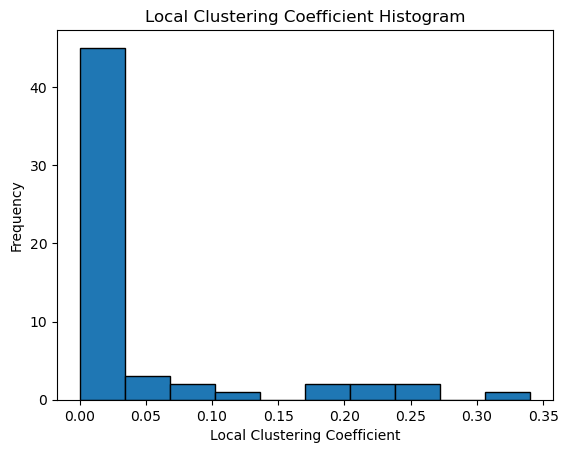

In [29]:
# Random generated ScaleFree network

scale_free_network = nx.scale_free_graph(n)

# create weighted graph from scale_free_network
Q = nx.DiGraph()
for u,v in scale_free_network.edges():
    if Q.has_edge(u,v):
        Q[u][v]['weight'] += 1
    else:
        Q.add_edge(u, v, weight=1)
        
# Lokalni Stepen klasterizacije

author, clustering_coef = zip(*nx.clustering(Q, weight = "weight").items())

nenula = [(auth, cc)  for auth, cc in zip(author, clustering_coef) if cc > 0]

df = pd.DataFrame(nenula, columns = ["Author", "Cc"])
df.sort_values('Cc', inplace = True)

max_lokalni_stepen_klasterisanja = max(clustering_coef)

prosecni_stepen_klasterisanja = nx.average_clustering(Q)

print(f"Max lokalni cc Random scale-free mreze: {max_lokalni_stepen_klasterisanja}")
print(f"Prosečan cc Random scale-free mreze: {prosecni_stepen_klasterisanja}")
print("Lokalni stepeni klasterisanja koji nisu nula Random scale-free mreze:")
print(df)


plt.hist(clustering_coef, bins=10, edgecolor='black')

# Postavite naslove i oznake osa
plt.title('Local Clustering Coefficient Histogram')
plt.xlabel('Local Clustering Coefficient')
plt.ylabel('Frequency')

plt.savefig('images/local_cc_random_scale_free_network.png')

# Prikazivanje histograma
plt.show()



In [30]:
# Asortativnost
# asortativnost na osnovu netežinskog stepena čvora
r1 = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti na osnovu netežinskog stepena čvora: {r1}")

# asortativnost na osnovu težinskog stepena čvora
r2 = nx.degree_assortativity_coefficient(G, weight='weight')
print(f"Koeficijent asortativnosti na osnovu težinskog stepena čvora: {r2}")



Koeficijent asortativnosti na osnovu netežinskog stepena čvora: -0.04122845538622359
Koeficijent asortativnosti na osnovu težinskog stepena čvora: -0.03255396785166119


In [31]:
# Rich club phenomenon; Havel-Hakimi algorithm

degrees = G.degree()
_, deg_list = zip(*degrees)
print(deg_list)

havel_hakimi_mreza = nx.havel_hakimi_graph(deg_list)

# nx.draw(havel_hakimi_mreza)

nx.write_gml(havel_hakimi_mreza, "models/havel_hakimi.gml")



(6, 15, 17, 8, 15, 4, 6, 30, 19, 10, 3, 11, 14, 16, 16, 22, 6, 7, 14, 7, 15, 9, 3, 8, 13, 9, 5, 8, 1, 12, 14, 15, 14, 21, 11, 7, 1, 12, 4, 12, 2, 13, 9, 9, 11, 12, 9, 12, 13, 12, 10, 9, 17, 3, 10, 8, 7, 8)


In [32]:
rich_club_coeffs = nx.rich_club_coefficient(G.to_undirected())
rich_club_coeffs_havel_hakimi = nx.rich_club_coefficient(havel_hakimi_mreza)

if rich_club_coeffs:
    degrees = list(rich_club_coeffs.keys())
    coefficients = list(rich_club_coeffs.values())
    print(degrees)
    print(coefficients)
    plt.plot(degrees, coefficients, marker='o')
    plt.xlabel('Degree (k)')
    plt.ylabel('Rich-club Coefficient')
    plt.title('Rich-club Phenomenon')
    plt.show()
else:
    print("Mreža ne sadrži dovoljno čvorova za analizu rich-club fenomena.")

if rich_club_coeffs_havel_hakimi:
    degrees = list(rich_club_coeffs_havel_hakimi.keys())
    coefficients = list(rich_club_coeffs_havel_hakimi.values())
    print(degrees)
    print(coefficients)
    plt.plot(degrees, coefficients, marker='o', color='red')
    plt.xlabel('Degree (k)')
    plt.ylabel('Rich-club Coefficient')
    plt.title('Rich-club Phenomenon Havel-Hakimi')
    plt.show()
else:
    print("Mreža ne sadrži dovoljno čvorova za analizu rich-club fenomena.")




ZeroDivisionError: float division by zero

In [ ]:
# Power law raspodela



degrees = dict(G.degree())
degree_values = list(degrees.values())

plt.hist(degree_values, bins=30, log=True)
plt.title('Histogram Distribucije Stepena')
plt.xlabel('Stepen čvora')
plt.ylabel('Broj čvorova (log skala)')
plt.show()

In [ ]:
# Asortativno mesanje

def plot_deg_corr(g, xscale = "linear", yscale = "linear"):
    first = []
    second = []
    for i, k in g.edges():
        first.append(g.degree(i))
        first.append(g.degree(k))
        second.append(g.degree(k))
        second.append(g.degree(i))

    plt.figure(1)   

    plt.xlabel('degree')                                                                                                             
    plt.xscale(xscale)                                                                                                                
    plt.xlim(1, max(first)) 

    plt.ylabel('degree')                                                                                                          
    plt.yscale(yscale)                                                                                                                
    plt.ylim(1, max(second))                                                                                                             

    plt.scatter(first, second, marker='.')                                                                                                    
    plt.show()

plot_deg_corr(G)

assortativity = nx.degree_assortativity_coefficient(G)
print(f"Koeficijent asortativnosti mesanja: {assortativity}")

### 2.3 Analiza mera centralnosti (5 poena)

In [ ]:
def calculate_centralities(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)

    df1 = pd.DataFrame.from_dict(DC_dict, orient='index', columns=['DC'])
    df2 = pd.DataFrame.from_dict(CC_dict, orient='index', columns=['CC'])
    df3 = pd.DataFrame.from_dict(BC_dict, orient='index', columns=['BC'])
    df4 = pd.DataFrame.from_dict(EVC_dict, orient='index', columns=['EVC'])
    df = pd.concat([df1, df2, df3, df4], axis=1)
    return df


calcCentralitiesDf = calculate_centralities(G)
print(calcCentralitiesDf)

print(calcCentralitiesDf.dtypes)


 

In [ ]:
def calculate_centralities_v2(G):

    DC_dict = nx.degree_centrality(G)
    CC_dict = nx.closeness_centrality(G)
    BC_dict = nx.betweenness_centrality(G)
    EVC_dict = nx.eigenvector_centrality(G)
        
    df1 = pd.DataFrame(list(DC_dict.items()), columns=['Author', 'Degree centrality'])
    df2 = pd.DataFrame(list(CC_dict.items()), columns=['Author', 'Closeness centrality'])
    df3 = pd.DataFrame(list(BC_dict.items()), columns=['Author', 'Betweenness centrality'])
    df4 = pd.DataFrame(list(EVC_dict.items()), columns=['Author', 'Eigenvector centrality'])
    df = df1.merge(df2,on='Author').merge(df3,on='Author').merge(df4,on='Author')
    return df


centralitiesDf = calculate_centralities_v2(G)

centralitiesDf = centralitiesDf.merge(authorsData, left_on='Author', right_on='Kratko ime', how='inner')

centralitiesDf.sort_values(by='Degree centrality', ascending=False).head(-1)

In [ ]:
centralitiesDf.sort_values(by='Eigenvector centrality', ascending=False).head(-1)

In [ ]:
# Heuristika
labele = ['DC', 'CC', 'BC', 'EVC']
cross_correlation_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])
p_val_matrix = pd.DataFrame(columns = ['DC', 'CC', 'BC', 'EVC'], index = ['DC', 'CC', 'BC', 'EVC'])

for ind in labele:
    for col in labele:
        cross_correlation_matrix[ind][col], p_val_matrix[ind][col] = stats.kendalltau(calcCentralitiesDf[ind], calcCentralitiesDf[col])

print(cross_correlation_matrix)
print(p_val_matrix)

In [ ]:
df_ = calculate_centralities(G)
for metric in labele:
    df_[f"{metric}_rank"] = df_[f"{metric}"].rank(ascending=False) 
    
df_['composite_rank'] = df_['DC_rank'] * df_['CC_rank'] * df_['BC_rank'] * df_['EVC_rank']

df_.sort_values(['composite_rank'], ascending = True)
#  df_.sort_values(['CC'], ascending = False, inplace=True)

In [ ]:
df_.head(-1)

## 3. Detkecija komuna spektralnim klasterisanjem

In [ ]:
# # Grivan-Newman Method

# grivanNewman = nx.community.girvan_newman(G)
# print(grivanNewman)

# k = 10
# limited = itertools.takewhile(lambda c: len(c) <= k, grivanNewman)
# for communities in limited:
#     print(tuple(sorted(c) for c in communities))

{'icoord': [[45.0, 45.0, 55.0, 55.0],
  [35.0, 35.0, 50.0, 50.0],
  [25.0, 25.0, 42.5, 42.5],
  [15.0, 15.0, 33.75, 33.75],
  [24.375, 24.375, 65.0, 65.0],
  [5.0, 5.0, 44.6875, 44.6875],
  [24.84375, 24.84375, 75.0, 75.0],
  [135.0, 135.0, 145.0, 145.0],
  [125.0, 125.0, 140.0, 140.0],
  [115.0, 115.0, 132.5, 132.5],
  [105.0, 105.0, 123.75, 123.75],
  [95.0, 95.0, 114.375, 114.375],
  [85.0, 85.0, 104.6875, 104.6875],
  [94.84375, 94.84375, 155.0, 155.0],
  [124.921875, 124.921875, 165.0, 165.0],
  [144.9609375, 144.9609375, 175.0, 175.0],
  [159.98046875, 159.98046875, 185.0, 185.0],
  [172.490234375, 172.490234375, 195.0, 195.0],
  [183.7451171875, 183.7451171875, 205.0, 205.0],
  [194.37255859375, 194.37255859375, 215.0, 215.0],
  [204.686279296875, 204.686279296875, 225.0, 225.0],
  [49.921875, 49.921875, 214.8431396484375, 214.8431396484375],
  [275.0, 275.0, 285.0, 285.0],
  [265.0, 265.0, 280.0, 280.0],
  [255.0, 255.0, 272.5, 272.5],
  [245.0, 245.0, 263.75, 263.75],
  [254.3

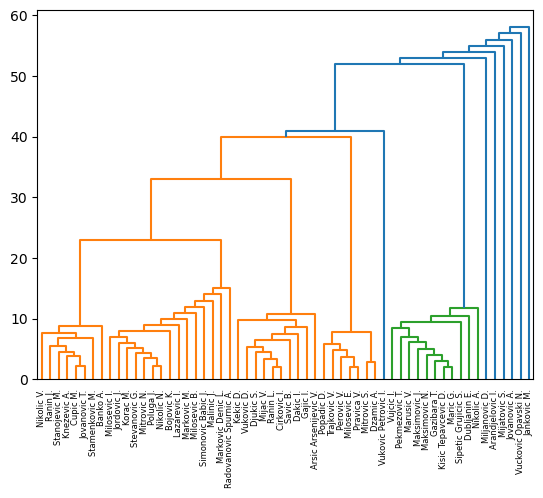

In [33]:
grivanNewman = nx.community.girvan_newman(G)

k = 6  # postavite željeni broj komuna
communities = list(sorted(c) for c in next(grivanNewman) if len(c) >= k)

# G = nx.path_graph(10)
communities = list(nx.community.girvan_newman(G))

# building initial dict of node_id to each possible subset:
node_id = 0
init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
for comm in communities:
    for subset in list(comm):
        if subset not in init_node2community_dict.values():
            node_id += 1
            init_node2community_dict[node_id] = subset

# turning this dictionary to the desired format in @mdml's answer
node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
    for node_id_parent, group in init_node2community_dict.items():
        if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
            node_id_to_children[node_id_parent].append(node_id1)
            node_id_to_children[node_id_parent].append(node_id2)

# also recording node_labels dict for the correct label for dendrogram leaves
node_labels = dict()
for node_id, group in init_node2community_dict.items():
    if len(group) == 1:
        node_labels[node_id] = list(group)[0]
    else:
        node_labels[node_id] = ''

# also needing a subset to rank dict to later know within all k-length merges which came first
subset_rank_dict = dict()
rank = 0
for e in communities[::-1]:
    for p in list(e):
        if tuple(p) not in subset_rank_dict:
            subset_rank_dict[tuple(sorted(p))] = rank
            rank += 1
subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

# my function to get a merge height so that it is unique (probably not that efficient)
def get_merge_height(sub):
    sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
    n = len(sub_tuple)
    other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
    min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
    range = (max_rank-min_rank) if max_rank > min_rank else 1
    return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

# finally using @mdml's magic, slightly modified:
G           = nx.DiGraph(node_id_to_children)
nodes       = G.nodes()
leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

# Compute the size of each subtree
subtree = dict( (n, [n]) for n in leaves )
for u in inner_nodes:
    children = set()
    node_list = list(node_id_to_children[u])
    while len(node_list) > 0:
        v = node_list.pop(0)
        children.add( v )
        node_list += node_id_to_children[v]
    subtree[u] = sorted(children & leaves)

inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

# Construct the linkage matrix
leaves = sorted(leaves)
index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
Z = []
k = len(leaves)
for i, n in enumerate(inner_nodes):
    children = node_id_to_children[n]
    x = children[0]
    for y in children[1:]:
        z = tuple(sorted(subtree[x] + subtree[y]))
        i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
        Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
        index[z] = k
        subtree[z] = list(z)
        x = z
        k += 1

# dendrogram
plt.figure()
dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])

In [ ]:
# U gephi stavili 2.5 za Community Detection, za slucaj slican dendogramu

In [ ]:
# Importovanje potrebne biblioteke
from sklearn.cluster import SpectralClustering

# Definisanje broja klastera
n_clusters = 3

# Izračunavanje spektralnog klasterisanja
clustering = SpectralClustering(n_clusters=n_clusters, assign_labels="discretize", affinity="precomputed").fit(nx.adjacency_matrix(G).toarray())

colors = clustering.labels_
c_string = []
for c in colors:
    c_string.append(str(c))

spectral_clust_graph = nx.Graph()
for c, label in zip(c_string, G.nodes()):
    spectral_clust_graph.add_node(label, color=c)

for edge in G.edges(data=True):
    #print(edge)
    spectral_clust_graph.add_edge(edge[0], edge[1], weight=edge[2]['weight'])

nx.write_pajek(spectral_clust_graph, "models/spectral4.net")

csizes = np.zeros(n_clusters)
for c in colors:
    csizes[int(c)] += 1

print(f"Podela na {n_clusters}: velicine komponenata su {csizes}")